Number of valid records: 53
Sample valid record paths:
  - ../bidmc/bidmc01
  - ../bidmc/bidmc02
  - ../bidmc/bidmc03
  - ../bidmc/bidmc04
  - ../bidmc/bidmc05
  - ../bidmc/bidmc06
  - ../bidmc/bidmc07
  - ../bidmc/bidmc08
  - ../bidmc/bidmc09
  - ../bidmc/bidmc10
  - ../bidmc/bidmc11
  - ../bidmc/bidmc12
  - ../bidmc/bidmc13
  - ../bidmc/bidmc14
  - ../bidmc/bidmc15
  - ../bidmc/bidmc16
  - ../bidmc/bidmc17
  - ../bidmc/bidmc18
  - ../bidmc/bidmc19
  - ../bidmc/bidmc20
  - ../bidmc/bidmc21
  - ../bidmc/bidmc22
  - ../bidmc/bidmc23
  - ../bidmc/bidmc24
  - ../bidmc/bidmc25
  - ../bidmc/bidmc26
  - ../bidmc/bidmc27
  - ../bidmc/bidmc28
  - ../bidmc/bidmc29
  - ../bidmc/bidmc30
  - ../bidmc/bidmc31
  - ../bidmc/bidmc32
  - ../bidmc/bidmc33
  - ../bidmc/bidmc34
  - ../bidmc/bidmc35
  - ../bidmc/bidmc36
  - ../bidmc/bidmc37
  - ../bidmc/bidmc38
  - ../bidmc/bidmc39
  - ../bidmc/bidmc40
  - ../bidmc/bidmc41
  - ../bidmc/bidmc42
  - ../bidmc/bidmc43
  - ../bidmc/bidmc44
  - ../bidmc/bidmc45


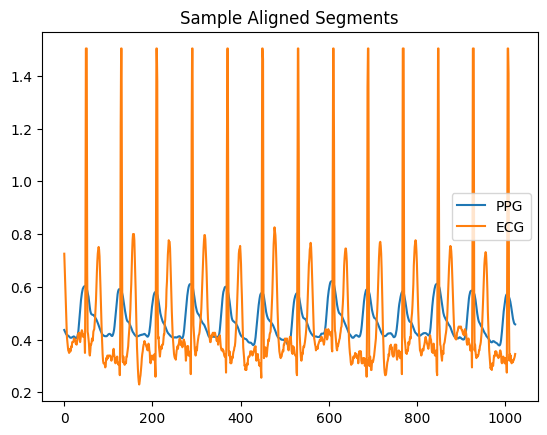

In [21]:
#testing loading_and_filtering_, Preprocessor
import sys
sys.path.append(os.path.abspath(".."))
from src.data.loading import loading_and_filtering_
from src.data.preprocessing import Preprocessor


database_path = "../bidmc"
records_file_path = f"{database_path}/RECORDS"
required_signal = ["PLETH,", "II,"]
sampling_freq = 125
min_duration = 8  # in minutes

 #Step 1: Load valid record paths--
valid_records = loading_and_filtering_(database_path=database_path,
    file_path=records_file_path,
    min_duration=min_duration,
    required_signal=required_signal,
    sampling_freq=sampling_freq
)

# --- Simple test output ---
print(f"Number of valid records: {len(valid_records)}")
print("Sample valid record paths:")
for path in valid_records:
    print(f"  - {path}")

# Step 2: Create a Preprocessor instance
record_path = valid_records[0]
pre = Preprocessor(record_path)

# Step 3: Fetch one sample and print its shape
ppg_tensor, ecg_tensor = pre[0]
print("PPG tensor shape:", ppg_tensor.shape)
print("ECG tensor shape:", ecg_tensor.shape)

# Optional: Plot if you want to visualize
import matplotlib.pyplot as plt
plt.plot(ppg_tensor.squeeze().numpy(), label="PPG")
plt.plot(ecg_tensor.squeeze().numpy(), label="ECG")
plt.legend()
plt.title("Sample Aligned Segments")
plt.show()

In [32]:
#teststing wnet1d
from src.models.wnet1d import WNet1D
# Create the model
model = WNet1D()

# Print architecture
print("Model Architecture:\n", model)

# Create dummy input and run a forward pass
import torch
dummy_input = torch.randn(1,1,1024)  # [batch, channel, time], adjust as needed
output = model(dummy_input)
print("Output shape:", output.shape)

Model Architecture:
 WNet1D(
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (enc1_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 24, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv1d(24, 48, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv1d(48, 72, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv1d(72, 96, kernel_size

In [36]:
#Testing loss func
from src.models.loss_func import CombinedSignalLoss
import torch.nn.functional as F
def test_combined_signal_loss_correctness():
    torch.manual_seed(42)

    batch_size = 4
    signal_length = 100

    predictions = torch.randn(batch_size, signal_length)
    targets = torch.randn(batch_size, signal_length)

    # Create loss function instance with equal weights for simplicity
    loss_fn = CombinedSignalLoss(mae_weight=1.0, mse_weight=1.0, pcc_weight=1.0)

    # Calculate loss from the class
    total_loss = loss_fn(predictions, targets)

    # Manually calculate components
    pred_flat = predictions.reshape(-1)
    targ_flat = targets.reshape(-1)

    mae_loss = F.l1_loss(pred_flat, targ_flat)
    mse_loss = F.mse_loss(pred_flat, targ_flat)

    # Pearson correlation calculation manually:
    vx = pred_flat - torch.mean(pred_flat)
    vy = targ_flat - torch.mean(targ_flat)
    numerator = torch.sum(vx * vy)
    denominator = torch.sqrt(torch.sum(vx ** 2) + loss_fn.eps) * torch.sqrt(torch.sum(vy ** 2) + loss_fn.eps)
    pcc = numerator / denominator
    pcc_loss = 1 - pcc

    manual_total = mae_loss + mse_loss + pcc_loss

    # Check if they are close enough (float tolerance)
    assert torch.isclose(total_loss, manual_total, atol=1e-6), (
        f"Mismatch: CombinedSignalLoss = {total_loss.item()}, manual total = {manual_total.item()}"
    )
    print("Test passed: CombinedSignalLoss matches manual calculation.")

test_combined_signal_loss_correctness()

Test passed: CombinedSignalLoss matches manual calculation.
